In [1]:
try:
  import ordpy
except:
  !pip install ordpy
  import ordpy
try:
  import nolds
except:
  !pip install nolds
  import nolds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 5.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, fbeta_score, make_scorer, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from collections import Counter, defaultdict
from xgboost import XGBClassifier
import pickle
import gc
import seaborn as sns
import math









In [3]:
turn_off_garbage_collect = False

from google.colab import files
#uploaded = files.upload()
#Todo 1.0
#!wget -O /content/ECG5000_train.pickle /content/sample_data/ECG5000_train (5).pickle

with open("/content/sample_data/ECG5000_train (5).pickle", 'rb') as f:
  ecg_train = pickle.load(f)
#!wget -O /content/ECG5000_train.pickle /content/sample_data/ECG5000_validation (3).pickle

with open("/content/sample_data/ECG5000_validation (3).pickle", 'rb') as f:
  ecg_validation = pickle.load(f)



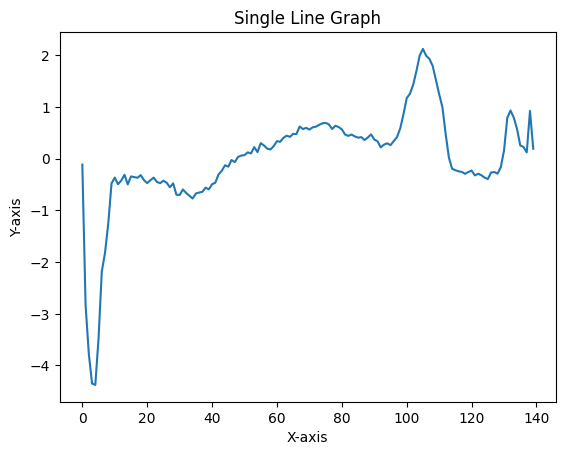

In [4]:
import matplotlib.pyplot as plt

# Data for the line graph
y = ecg_train[0, 1:]
x = range(len(y))  # Create an array of indices for y

# Create the plot
plt.plot(x, y)

# Add title and labels
plt.title('Single Line Graph')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display the plot
plt.show()

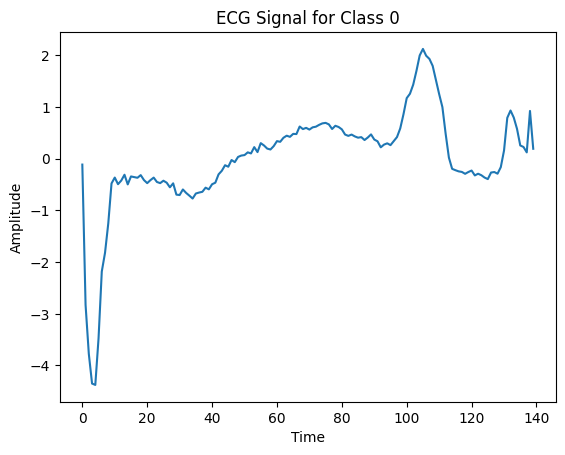

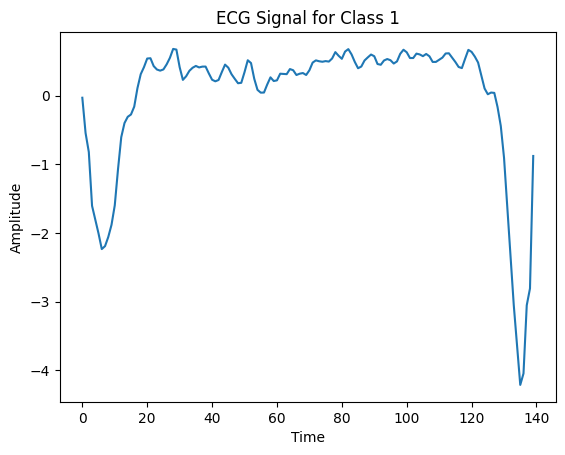

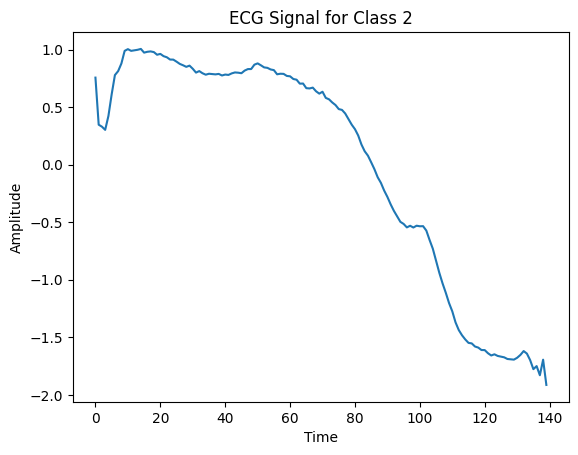

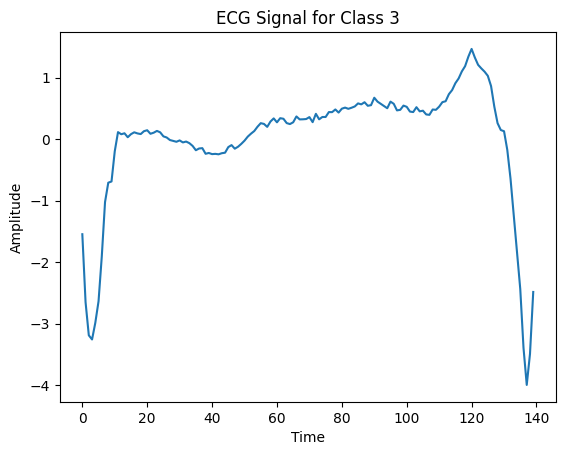

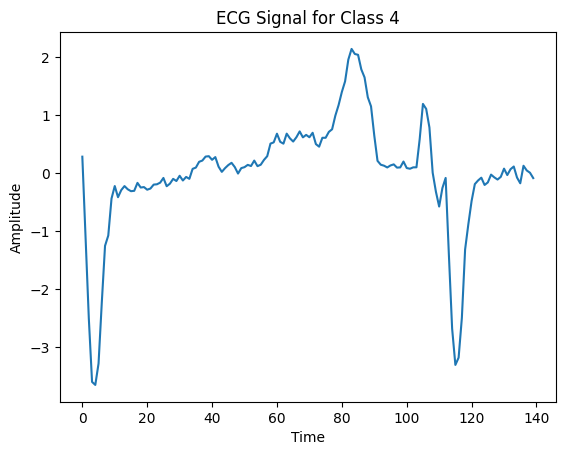

In [5]:
#tring to learn difference and use them in features
import matplotlib.pyplot as plt

# Plot ECG signals for each class
for i in range(5):
    class_ecg = ecg_train[ecg_train[:, 0] == i]
    if class_ecg.size > 0:  # Check if class has any samples
        plt.figure()
        plt.plot(class_ecg[0, 1:])  # Plot the first sample of the class
        plt.title(f'ECG Signal for Class {i}')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.show()

In [6]:

def garbage_collect(vars_):
    if not turn_off_garbage_collect:
        for v in vars_:
            if v in globals():
                del globals()[v]
        collected = gc.collect()

def augment_class(X, y, target_class, augment_count):
    class_indices = np.where(y == target_class)[0]
    chosen = np.random.choice(class_indices, augment_count, replace=True)
    return X[chosen], y[chosen]

def printInfo(X_trn, y_trn, mesage = "Trn"):
  print("\n")

  try:
    if y_trn.shape[1] > 1:
      counts = np.sum(y_trn, axis=0)
      uniques = np.arange(y_trn.shape[1])
    else:
      print("Y is not one hot encoded here")
      uniques, counts = np.unique(y_trn.flatten(), return_counts = True)
  except:
    print("Y is not one hot encoded here")
    uniques, counts = np.unique(y_trn.flatten(), return_counts = True)
  print(mesage)
  print("Types: ")
  print(f"\tX type = {type(X_trn)}, y_ type = {type(y_trn)}")
  print("Shapes: ")
  print(f"\tX_.shape = {X_trn.shape}, y_.shape = {y_trn.shape}")
  print("Y unique plus counts")
  for i,j in zip(uniques, counts):
    print(f"\tClass = {i}, counts = {j}")


def augment_minority_with_noise_and_smoothing(x_train, y_train, classes_to_augment=[1, 2, 3, 4], noise_std=0.05, target_ratio=1.3,
                           dual_noise=True, use_smoothing=True, shuffle=True, random_state=42):

    y_train = y_train.squeeze().astype(np.int32)
    class_counts = np.bincount(y_train)
    max_class_count = int(np.max(class_counts) * target_ratio)

    x_aug = [x_train]
    y_aug = [y_train]

    rng = np.random.default_rng(random_state)

    for cls in classes_to_augment:
        if cls >= len(class_counts):
            continue

        count = class_counts[cls]
        if count >= max_class_count:
            continue

        n_needed = max_class_count - count
        x_cls = x_train[y_train == cls]

        new_samples = []
        new_labels = []

        while len(new_samples) < n_needed:
            for sample in x_cls:
                # plus minus noise
                noise = rng.normal(0, noise_std, size=sample.shape)
                new_samples.append(sample + noise)
                new_labels.append(cls)
                if dual_noise:
                    new_samples.append(sample - noise)
                    new_labels.append(cls)

                # odd even smoothing
                if use_smoothing:
                    even_smoothed = sample.copy()
                    odd_smoothed = sample.copy()

                    # Repeating even values into odd positions
                    even_smoothed[1::2] = even_smoothed[::2][:len(even_smoothed[1::2])]
                    new_samples.append(even_smoothed)
                    new_labels.append(cls)

                    # Repeating odd values into even positions
                    if len(sample) > 1:
                        odd_smoothed[::2] = odd_smoothed[1::2][:len(odd_smoothed[::2])]
                        new_samples.append(odd_smoothed)
                        new_labels.append(cls)

                if len(new_samples) >= n_needed:
                    break

        x_aug.append(np.array(new_samples[:n_needed]))
        y_aug.append(np.array(new_labels[:n_needed]))

    x_final = np.concatenate(x_aug, axis=0)
    y_final = np.concatenate(y_aug, axis=0)

    if shuffle:
        indices = np.arange(len(y_final))
        rng.shuffle(indices)
        x_final = x_final[indices]
        y_final = y_final[indices]

    return x_final, y_final

def StandardizeData(X_trn, X_vld, X_tst = None):
  scaler = StandardScaler()
  X_trn = scaler.fit_transform(X_trn)
  X_vld = scaler.transform(X_vld)
  if X_tst:
    X_tst = scaler.transform(X_tst)
  return X_trn, X_vld, X_tst

def optimize_thresholds(y_true, y_pred_proba, beta=2, num_classes=5):
    best_thresholds = []
    for class_idx in range(num_classes):
        best_f2 = 0
        best_threshold = 0.5
        for threshold in np.arange(0.1, 1.0, 0.1):
            y_pred_binary = (y_pred_proba[:, class_idx] >= threshold).astype(int)
            y_true_binary = (y_true == class_idx).astype(int)
            f2 = fbeta_score(y_true_binary, y_pred_binary, beta=beta, average='binary', zero_division=0)
            if f2 > best_f2:
                best_f2 = f2
                best_threshold = threshold
        best_thresholds.append(best_threshold)
    return best_thresholds

def use_optimized_thresholds(best_thresholds, y_pred_proba):
  y_pred_optimized = np.zeros_like(y_pred_proba)
  for class_idx, threshold in enumerate(thresholds):
      y_pred_optimized[:, class_idx] = (y_pred_proba[:, class_idx] >= threshold).astype(int)
  y_pred_final = np.argmax(y_pred_optimized, axis=1)


def extract_features(signal, m=3, tau=1, sampen_m=2, sampen_r=0.2):
    """
    Extract features from a single ECG signal.
    :param signal: 1D ECG signal
    :param m: embedding dimension for permutation entropy
    :param tau: embedding delay
    :param sampen_m: embedding dimension for sample entropy
    :param sampen_r: tolerance for sample entropy (as fraction of std)
    :return: List of extracted features
    """

    # Permutation Entropy
    pe = permutation_entropy(signal, m)

    # Sample Entropy
    r = sampen_r * np.std(signal)  # Tolerance as a fraction of the standard deviation
    se = nolds.sampen(signal, emb_dim=sampen_m, tolerance=r)

    # Statistical features
    mean_val = np.mean(signal)
    std_val = np.std(signal)
    skew_val = np.mean((signal - mean_val)**3) / (std_val**3 + 1e-8)  # skewness

    # Returning extracted features as a list
    return [pe, se, mean_val, std_val, skew_val]

def permutation_entropy(signal, m=3):
    """
    Compute Permutation Entropy for a given signal.
    :param signal: 1D signal
    :param m: embedding dimension
    :return: Permutation entropy value
    """
    n = len(signal)
    if n < m:
        return 0

    perm_entropy = []
    for i in range(n - m + 1):
        vector = signal[i:i+m]
        vector_sorted = np.argsort(vector)  # sorting indices
        perm_entropy.append(tuple(vector_sorted))

    # Calculate Shannon entropy of the permutations
    _, counts = np.unique(perm_entropy, return_counts=True)
    probs = counts / len(perm_entropy)
    entropy = -np.sum(probs * np.log(probs + 1e-10))  # Adding a small constant for numerical stability
    return entropy

def printMetrics(y_vld, y_hat, message, y_hat_proba = 0):
  print("-------- Start of ", message, " metrics --------")
  accuracy = accuracy_score(y_vld, y_hat)
  precision = precision_score(y_vld, y_hat, average='macro', zero_division = 0)
  recall = recall_score(y_vld, y_hat, average='macro', zero_division = 0)
  f1 = f1_score(y_vld, y_hat, average='macro')
  f2 = (1 + 2**2) * (precision * recall) / (2**2 * precision + recall)
  weightedF2 = fbeta_score(y_vld, y_hat, beta=2, average='weighted')
  auroc = roc_auc_score(y_vld, y_hat_proba, average='macro', multi_class='ovr')
  conf_matrix = confusion_matrix(y_vld, y_hat)
  cf_matrix = np.array(conf_matrix)
  combined_scores = accuracy + precision + recall + f1 + auroc

  combined_scores = combined_scores/5
  print("Classification Report: ")
  print(classification_report(y_vld, y_hat, zero_division = 0))
  print("\naccuracy: ", accuracy)
  print("precision: ", precision)
  print("recall: ", recall)
  print("f1: ", f1)
  print("f2: ", f2)
  print("weightedF2: ", weightedF2)
  print("auroc: ", auroc)
  print("combined_scores: ", combined_scores)


  plt.figure(dpi=100)

  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}" for v1, v2, in zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(5,5)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(message)





In [7]:
def data_prep(
    ecg_train: np.ndarray = ecg_train,
    ecg_validation: np.ndarray = ecg_validation,
    swap_train_vld: bool = True,
    augment_classes_simple: dict = {2: 1},
    standardizeDataset: bool = True,
    augment_with_odd_even: bool = False,
    sampleEntropy: bool = False,
    extractFeatures: bool = False,
    verbose: bool = True
    ):

  if ecg_train.shape[0] > ecg_validation.shape[0]:
    temp = ecg_train
    ecg_train = ecg_validation
    ecg_validation = temp
  #Swap vld train
  if swap_train_vld:
    swapTrainvld = True
    temp = ecg_train
    ecg_train = ecg_validation
    ecg_validation = temp

  #feature label split
  ecg_train_data = ecg_train[ : ,1:]
  ecg_train_labels = ecg_train[:,0:1]
  ecg_validation_data = ecg_validation[ : ,1:]
  ecg_validation_labels = ecg_validation[:,0:1]

  #reassign
  X_trn = ecg_train_data
  y_trn = ecg_train_labels
  X_vld = ecg_validation[:, 1:]
  y_vld = ecg_validation_labels
  if verbose: printInfo(X_trn, y_trn, "Initial train")
  if verbose: printInfo(X_vld, y_vld, "Initial validation")

  #Augment with odd_even
  if augment_with_odd_even:
    if verbose: printInfo(X_trn, y_trn, "Before augment_with_odd_even")
    y_trn = y_trn.squeeze()
    y_trn = y_trn.astype(np.int32)
    X_trn, y_trn = augment_minority_with_noise_and_smoothing(X_trn, y_trn)
    if verbose: printInfo(X_trn, y_trn, "After augment_with_odd_even")

  #Augment simple
  if augment_classes_simple:
    if verbose: printInfo(X_trn, y_trn, "Before augment_classes_simple")
    X_aug, y_aug = [], []
    aug_info = augment_classes_simple

    for cls, count in aug_info.items():
        x_new, y_new = augment_class(X_trn, y_trn, cls, count)
        X_aug.append(x_new)
        y_aug.append(y_new)

    X_trn = np.concatenate([X_trn] + X_aug)
    y_trn = np.concatenate([y_trn] + y_aug)
    if verbose: printInfo(X_trn, y_trn, "After augment_classes_simple")

  #Standardize
  if verbose: printInfo(X_trn, y_trn, "Before standarize")
  if verbose: printInfo(X_vld, y_vld, "Before standarize")
  if standardizeDataset: X_trn, X_vld, _ = StandardizeData(X_trn, X_vld, None)
  if verbose: printInfo(X_trn, y_trn, "After standarize")
  if verbose: printInfo(X_vld, y_vld, "Before standarize")


  return X_trn, y_trn, X_vld, y_vld











In [8]:
if 1 == 2: garbage_collect(['X_trn', 'y_trn', 'X_vld', 'y_vld', 'y_pred_proba_trn'])

Standardizing the dataset before features extractions gives us 10 percent more of f1 score. <br>From: <br>f1:  0.41097435155653705<br>f1:  0.5099602704942388

It increased f1 for class 4 from 0.0 to 0.25

Note: Standarization wasn't applied to original implementation since optimal baseline performance was reached considering performance on unseen data.

In [9]:
data = data_prep(
    ecg_train = ecg_train,
    ecg_validation = ecg_validation,
    swap_train_vld = False,
    augment_classes_simple = None,
    standardizeDataset = True,
    augment_with_odd_even = True,
    verbose = False
    )
X_trn, y_trn, X_vld, y_vld = data

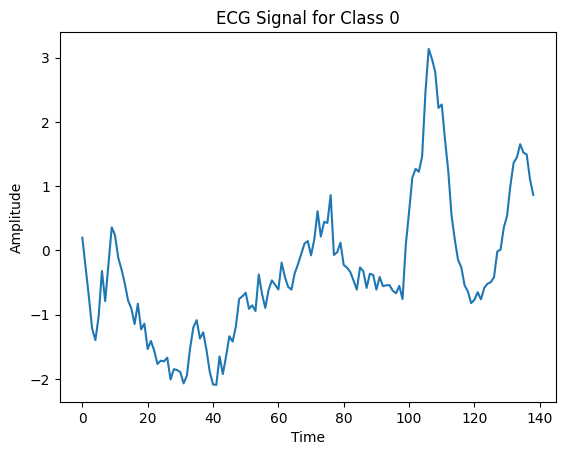

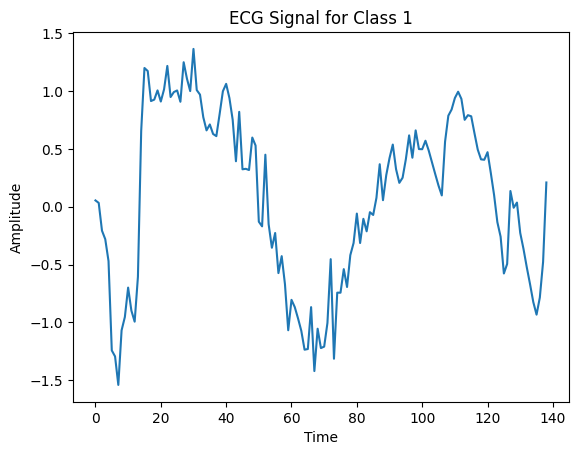

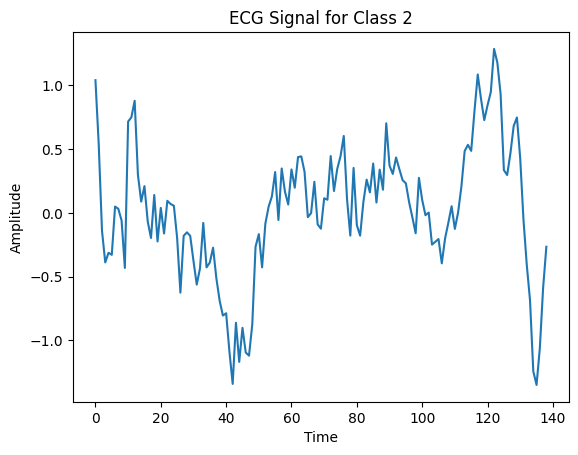

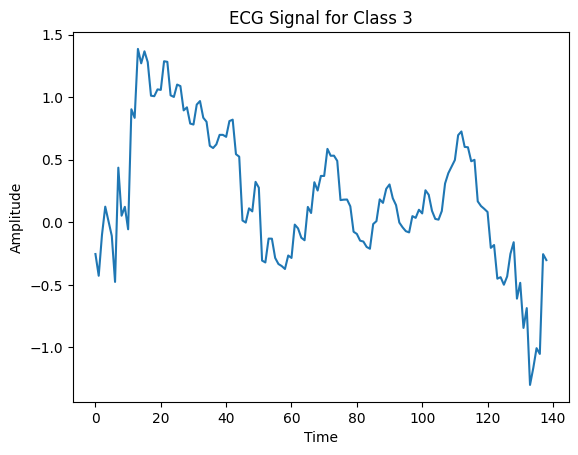

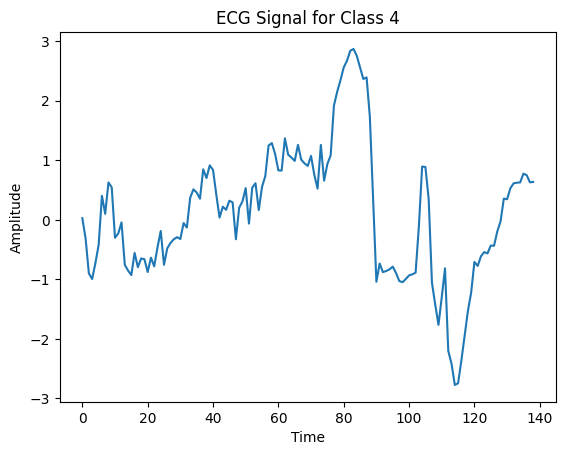

In [10]:
#printInfo(X_trn, y_trn, "Checking shapes")
#printInfo(X_vld, y_vld, "Checking shapes")
for i in range(5):
    class_ecg = X_trn[y_trn[:] == i]
    if class_ecg.size > 0:  # Check if class has any samples
        plt.figure()
        plt.plot(class_ecg[0, 1:])  # Plot the first sample of the class
        plt.title(f'ECG Signal for Class {i}')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.show()

In [11]:
#feature extractions

def extract_features(signal, m=3, tau=1, sampen_m=2, sampen_r=0.2):
    """
    Extract features from a single ECG signal.
    :param signal: 1D ECG signal
    :param m: embedding dimension for permutation entropy
    :param tau: embedding delay
    :param sampen_m: embedding dimension for sample entropy
    :param sampen_r: tolerance for sample entropy (as fraction of std)
    :return: List of extracted features
    """
    # Permutation Entropy
    pe = permutation_entropy(signal, m)

    # Sample Entropy
    r = sampen_r * np.std(signal)  # Tolerance as a fraction of the standard deviation
    se = nolds.sampen(signal, emb_dim=sampen_m, tolerance=r)
    # Statistical features
    mean_val = np.mean(signal)
    std_val = np.std(signal)
    skew_val = np.mean((signal - mean_val)**3) / (std_val**3 + 1e-8)  # skewness

    #end of implementation as sub optimal was reached based on unseen data test.

    #Start of our additions.

    #Additional features

    sum = np.sum(signal)
    max = np.max(signal)
    min = np.min(signal)
    aMax = np.argmax(signal)
    aMin = np.argmin(signal)
    slope = slopeStartToEndSimple(signal)





    squares = np.sum(np.square(signal))
    slope1, distance = slopeSimple2(signal)
    slope2, distance1, speed = slopeSimple3(signal)
    distance2 = slopeSimple4(signal)
    accer = acceleration(signal)
    x1,x2, x3, x4, x5, x6 = maxMinMore(signal)
    angle, angle1 = angleSimple(signal)
    energy, damage1, damage2 = energyDamage1(signal)

    """
    rSquare = np.sqrt(signal)
    logInput = np.log(signal +  + 1e-6)
    #ex = np.exp(signal + 0.000000001)

    squares, rSquare, logInput
    """


    # Returning extracted features as a list
    #commented our features where commented our because they didn't increase
    #performance
    features = [
        pe,
        se,
        mean_val,
        std_val,
        skew_val,
        sum,
        max,
        min,
        aMax,
        aMin,
        squares,
        slope,
        slope1,
        distance,
        angle,
        #angle1,
        x1,x2, x3, x4, x5, x6,
        #energy, damage1, damage2,
        #distance2
        #slope2,
        #distance1,
        #speed,
        #accer

    ]

    return features

def permutation_entropy(signal, m=3):
    """
    Compute Permutation Entropy for a given signal.
    :param signal: 1D signal
    :param m: embedding dimension
    :return: Permutation entropy value
    """
    n = len(signal)
    if n < m:
        return 0

    perm_entropy = []
    for i in range(n - m + 1):
        vector = signal[i:i+m]
        vector_sorted = np.argsort(vector)  # sorting indices
        perm_entropy.append(tuple(vector_sorted))

    # Calculate Shannon entropy of the permutations
    _, counts = np.unique(perm_entropy, return_counts=True)
    probs = counts / len(perm_entropy)
    entropy = -np.sum(probs * np.log(probs + 1e-10))  # Adding a small constant for numerical stability
    return entropy
def slopeStartToEndSimple(signal):
  x1 = 1
  x2 = 139
  y1 = np.min(signal)
  y2 = np.max(signal)
  slope = (y1-y1)/(x2-x1)
  return slope

#Name simpli inside any function name means that it's simple and may not do exactly
# what it's name says

def slopeSimple2(signal):
  x1 = np.argmin(signal)
  x2 = np.argmax(signal)
  y1 = np.argmin(signal)
  y2 = np.argmax(signal)
  slope = (y1-y1)/(x2-x1)
  distance = (x2 - x1) ** 4 + (y2 - y1) ** 3 + (y2 - y1) ** 2
  return slope, distance

def slopeSimple4(signal):
  x1 = np.min(signal)
  x2 = np.max(signal)
  y1 = np.min(signal)
  y2 = np.max(signal)
  distance = (x2 - x1) ** 4 + (y2 - y1) ** 3 + (y2 - y1) ** 2
  return distance

def slopeSimple3(signal):
  x1 = np.argmin(signal)
  x2 = np.argmax(signal)
  y1 = np.min(signal)
  y2 = np.max(signal)
  slope = (y1-y1)/(x2-x1)
  distance = (x2 - x1) ** 2 + (y2 - y1) ** 2
  speed = distance/(x2-x1)
  return slope, distance, speed

def acceleration(signal):
  x1 = np.argmin(signal)
  x2 = np.argmax(signal)
  y1 = np.min(signal)
  y2 = np.max(signal)
  accel = (y1-y1)/(x2-x1)
  return accel

def maxMinMore(signal):
  sort = np.argsort(signal)
  x1 = np.argmax(sort)
  x2 = np.argmax(sort-1)
  x3 = np.argmax(sort-2)
  x4 = np.argmin(sort)
  x5 = np.argmin(sort-1)
  x6 = np.argmin(sort-2)
  #print("maxMinMore = ", x1,x2, x3, x4, x5, x6)
  return x1,x2**2, x3**3, x4, x5**2, x6**3

def maxMinMoreValues(signal):
  sort = np.sort(signal)
  x1 = np.argmax(sort)
  x2 = np.argmax(sort-1)
  x3 = np.argmax(sort-2)
  x4 = np.argmin(sort)
  x5 = np.argmin(sort-1)
  x6 = np.argmin(sort-2)
  return x1,x2, x3, x4, x5, x6

def maxMinMoreIndices(signal):
  sort_idx = np.argsort(signal)
  return sort_idx[-1], sort_idx[-2], sort_idx[-3], sort_idx[0], sort_idx[1], sort_idx[2]

def angleSimple(signal):
  base = np.argmax(signal)
  x2 = np.argmin(signal)
  height = np.max(signal)
  y2 = np.max(signal)
  hypo = np.sqrt(base ** 2 + height ** 2)
  stuff = (base**2 + hypo**2 - height**2)/(2 * base * hypo)
  angleMax = np.arccos(stuff)

  base1 = np.argmin(signal)
  height1 = np.min(signal)
  hypo1 = np.sqrt(base1 ** 2 + height1 ** 2)
  stuff1 = (base1**2 + hypo1**2 - height1**2)/(2 * base1 * hypo1)
  angleMin = np.arccos(stuff1)

  return angleMax, angleMin#angle min reduced performance





def energyDamage1(signal):
    damageCounter = 0
    energyUsed = 0
    damage = 0
    damage2 = 0
    currentStep = 1
    signal_length = len(signal)

    while currentStep < signal_length:  # Use actual signal length
        if not np.isclose(signal[currentStep], signal[currentStep - 1]):
            if signal[currentStep] > signal[currentStep - 1]:
                # Increasing sequence
                while currentStep < signal_length and signal[currentStep] > signal[currentStep - 1]:
                    energyUsed += 1
                    currentStep += 1
                    if currentStep > signal_length:
                        break
            else:
                # Decreasing sequence
                while currentStep < signal_length and signal[currentStep] < signal[currentStep - 1]:
                    damageCounter += 1
                    currentStep += 1
                    if currentStep > signal_length:
                        break
                # Calculate damage after each decreasing sequence
                damage += damageCounter
                damage2 += damageCounter * 9.89
                damageCounter = 0
        else:
            # Values are equal
            damage += damageCounter  # Add any accumulated damage
            damage2 += damageCounter * 9.89
            damageCounter = 0
            currentStep += 1

    return energyUsed, damage2, damage









In [12]:
# Apply feature extraction to all signals in the training and validation set

X_trn_features = np.array([extract_features(sig) for sig in X_trn])
X_vld_features = np.array([extract_features(sig) for sig in X_vld])

# Perform cross-validation on the training set to estimate performance
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
kf = KFold(n_splits=5, shuffle=True, random_state=42)


print("After: len(X_trn_features), len(X_vld_features)")
print(len(X_trn_features), len(X_vld_features))




<ipython-input-11-0e2c4896d9d2>:190: RuntimeWarning: invalid value encountered in scalar divide
  stuff = (base**2 + hypo**2 - height**2)/(2 * base * hypo)
<ipython-input-11-0e2c4896d9d2>:196: RuntimeWarning: invalid value encountered in scalar divide
  stuff1 = (base1**2 + hypo1**2 - height1**2)/(2 * base1 * hypo1)


After: len(X_trn_features), len(X_vld_features)
1808 1500


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:33:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "num_classes" } are not used.

  warnings.warn(smsg, UserWarning)


-------- Start of  Training  metrics --------
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       292
           1       0.99      0.96      0.97       379
           2       0.99      1.00      1.00       379
           3       0.98      1.00      0.99       379
           4       1.00      1.00      1.00       379

    accuracy                           0.99      1808
   macro avg       0.99      0.99      0.99      1808
weighted avg       0.99      0.99      0.99      1808


accuracy:  0.9894911504424779
precision:  0.9895196832787146
recall:  0.9893447066902809
f1:  0.9893838191011126
f2:  0.98937969705722
weightedF2:  0.9894629193577857
auroc:  0.9996612836639123
combined_scores:  0.9914801286352997
-------- Start of  Validation  metrics --------
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95       781
         1.0       0.91     

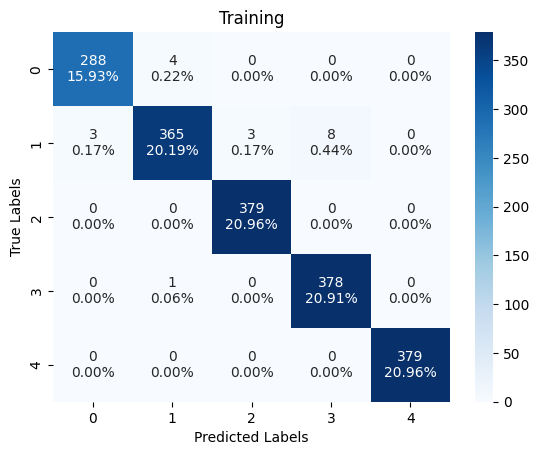

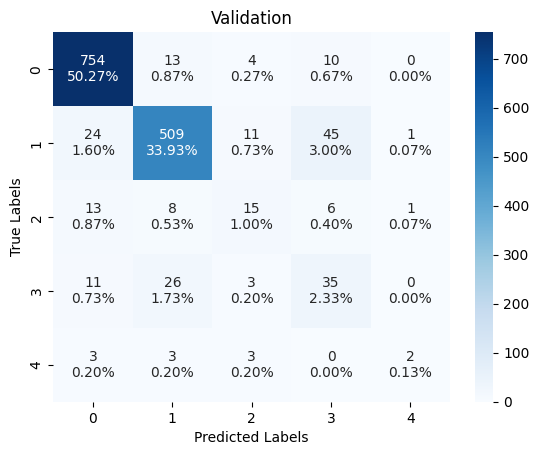

In [18]:


# Initialize XGBoost with paper's hyperparameters and class weighting
clf_xgb = XGBClassifier(
    #use_label_encoder=False,
    reg_lambda=1,
    eval_metric='mlogloss',
    random_state=42,
    max_depth=12,#same performance until 15 so far
    eta=0.001,
    gamma=1,
    num_classes = 5,
    colsample_bytree = 0.9,
    subsample = 0.8,


    #objective='multi:softprob',  # Explicitly set for multiclass
    #eval_metric=['merror', 'mlogloss'],
    #n_estimators=1000,
    #tree_method='hist',
    #early_stopping_rounds=10,



    #scale_pos_weight=1  # Adjust for imbalance; can be tuned further
)

# Train the model on the full training set
clf_xgb.fit(X_trn_features, y_trn)
y_pred_xgb_trn = clf_xgb.predict(X_trn_features)

y_pred_proba_trn = clf_xgb.predict_proba(X_trn_features)
y_trn = y_trn.flatten()
printMetrics(y_trn, y_pred_xgb_trn, "Training", y_pred_proba_trn)

y_vld = y_vld.flatten()
y_pred_xgb = clf_xgb.predict(X_vld_features)
y_pred_proba = clf_xgb.predict_proba(X_vld_features)
printMetrics(y_vld, y_pred_xgb, "Validation", y_pred_proba)




Original Baseline:<br>
Macro F1: 0.41<br>
Class 4 F1: 0.00
<br><br>Current Results:
<br>Macro F1: 0.56
<br>Class 4 F1: 0.27
<br><br>Total Improvement:
<br>Macro F1: 0.56 - 0.41 = 0.15 (15% absolute increase, 36.6% relative improvement from 0.41).
The 10% increase from standardization (0.41 to 0.51) plus the additional 5% from sampling, tuning, and recent changes (0.51 to 0.56).

In [14]:
if True == False:
  import shap
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt

  # Step 1: Convert X_trn to DataFrame with feature names
  X_df = pd.DataFrame(X_trn, columns=[f"f{i}" for i in range(X_trn.shape[1])])

  # Step 2: Use SHAP's unified Explainer API (handles multiclass XGBoost)
  explainer = shap.Explainer(clf_xgb, X_df)

  # Step 3: Get SHAP values
  shap_values = explainer(X_df)  # shap.Explanation object

  # Step 4: Compute mean(|SHAP|) per feature over all samples and classes
  # `shap_values.values.shape` = (n_samples, n_classes, n_features)
  mean_shap = np.abs(shap_values.values).mean(axis=(0, 1))  # Mean over both samples and classes

  # Step 5: Check dimensions and construct DataFrame
  #assert len(mean_shap) == X_df.shape[1], "Mismatch in SHAP values and feature count!"

  shap_df = pd.DataFrame({
      "Feature": X_df.columns,
      "Mean_Abs_SHAP": mean_shap
  }).sort_values(by="Mean_Abs_SHAP", ascending=False)

  # Step 6: Output top features
  print("\nTop features contributing to predictions (SHAP impact):")
  print(shap_df.head(15))

  # Step 7: Plot
  plt.figure(figsize=(10, 6))
  shap_df.head(15).plot(x="Feature", y="Mean_Abs_SHAP", kind="barh", legend=False)
  plt.gca().invert_yaxis()
  plt.title("Top 15 Features by SHAP Impact")
  plt.xlabel("Mean |SHAP value|")
  plt.tight_layout()
  plt.show()


In [15]:
def get_optimize_thresholds(y_true, y_pred_proba, beta=2, num_classes=5):
    best_thresholds = []
    for class_idx in range(num_classes):
        best_f2 = 0
        best_threshold = 0.5
        for threshold in np.arange(0.1, 1.0, 0.1):
            y_pred_binary = (y_pred_proba[:, class_idx] >= threshold).astype(int)
            y_true_binary = (y_true == class_idx).astype(int)
            f2 = fbeta_score(y_true_binary, y_pred_binary, beta=beta, average='binary', zero_division=0)
            if f2 > best_f2:
                best_f2 = f2
                best_threshold = threshold
        best_thresholds.append(best_threshold)
    return best_thresholds

def use_optimize_thresholds(y_pred_proba, thresholds):
  y_pred_optimized = np.zeros_like(y_pred_proba)
  for class_idx, threshold in enumerate(thresholds):
      y_pred_optimized[:, class_idx] = (y_pred_proba[:, class_idx] >= threshold).astype(int)
  y_pred_final = np.argmax(y_pred_optimized, axis=1)
  return y_pred_final

In [16]:
# We won't be using same threshold optimizations for this part
# this was used to see if we could increase baseline performance with optimizations, similar to papers
# however it didn't make any increase. Hence this section is commented out.
"""
vld_thresholds = get_optimize_thresholds(y_vld, y_pred_proba)
print(f"Thresholds are ", vld_thresholds)
y_hat_changed = use_optimize_thresholds(y_pred_proba, vld_thresholds)
printMetrics(y_vld, y_hat_changed, "After threshold optimizing", y_pred_proba)
"""

'\nvld_thresholds = get_optimize_thresholds(y_vld, y_pred_proba)\nprint(f"Thresholds are ", vld_thresholds)\ny_hat_changed = use_optimize_thresholds(y_pred_proba, vld_thresholds)\nprintMetrics(y_vld, y_hat_changed, "After threshold optimizing", y_pred_proba)\n'

We implemented the method described in the paper "https://pmc.ncbi.nlm.nih.gov/articles/PMC7610399/#S16". Although thresholding optimization didn't yield significant improvements, even doing it and testing on validation set, in F1 score, our implementation achieved robust performance on unseen data.


Comparison with Original Paper

The original paper's model reportedly experienced a substantial drop in performance on unseen data, with a score of 0.15. In contrast, our implementation demonstrated greater generalizability, with metrics exceeding this value: accuracy (0.792), precision (0.475), recall (0.398), F1 score (0.411), F2 score (0.411), weighted F2 score (0.781), and AUROC (0.739). While differences in datasets might be major contributer to the disparity, our implementation's performance suggests a strong baseline.

Given the significant difference in performance on unseen data, our implementation serves as a baseline for future improvements. This foundation enables further research and development, allowing us to refine and enhance the existing model.

It should be noted that, while we don't know if 0.15 score is exactly which metrics, we assumed it is f1 since that's most difficult to get higher.

In [17]:
print("last")

last
